## Multi-task recommenders

In [108]:
from typing import Dict, Text
from firebase import firebase

import os
import pprint
import tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_recommenders as tfrs

### Preparing the dataset

In [109]:
firebase = firebase.FirebaseApplication('firebase-key', None)
firebase_ratings = firebase.get('/User_Book', None)
firebase_books = firebase.get('/Books', None)

In [110]:
ratings_df = pd.DataFrame.from_dict(firebase_ratings, orient='index')
books_df = pd.DataFrame.from_dict(firebase_books, orient='index')

In [111]:
ratings_df.head()

,bookId,isbn,myRate,userId
-NWcEFgMwmdaYc-4ndml,-NWcEFeoVaEgjMwiboCA,09781565841000,5.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEGniRUJ0hRQmvclo,-NWcEGmQeH3eiHRZ0w7G,09781929610259,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEHtzsgGbN7rpUZ6V,-NWcEHsFfJ3yqXud1NGo,09780814326114,4.0,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcEJunG4PfX-aAVxiF,-NWcEJqjxIyMQv5izHrS,09780312010447,4.5,3avc3TUJioP8XGD0bLK9xtV7uIG3
-NWcELFol68JZpsfvkyF,-NWcELEEV0QR6EHobxIe,09780143036357,3.5,3avc3TUJioP8XGD0bLK9xtV7uIG3


In [112]:
len(set(books_df["isbn"]))

696

In [113]:
books_df.tail()

,author,description,documentId,genre,image,isbn,myRate,pages,publishedYear,rating,title,finishDate,pagesRead,startDate,notes
-NZ6TnNp0OS0Mn3DCvjt,Barbara Fairchild,"""You can always tell a Bon App?tit recipe: It'...",,Cooking,https://books.google.com/books/content?id=7VE-...,09780764596865,NaN,816,2006,4.06,The Bon Appetit Cookbook,NaN,NaN,NaN,NaN
-NZ6To1MjcsmbyVRQ791,Giada De Laurentiis,"Presents techniques of Italian home cookery, i...",,Cooking,https://books.google.com/books/content?id=OVsc...,09781400052585,NaN,256,2005,3.95,Everyday Italian,NaN,NaN,NaN,NaN
-NZ6Tod5icltvscrhwzK,Sophie Braimbridge;Erica Jankovich,A noted chef and a dietician join forces to cr...,,Cooking,https://books.google.com/books/content?id=cWLm...,09781584794943,NaN,144,2006,2.62,Healthy Cooking for IBS,NaN,NaN,NaN,NaN
-NZ6TpPNzFU5ADOOyZJg,Garth Ennis;Jeff Youngquist;John McCrea,The most deadly man in the Marvel Universe--Th...,,Comics & Graphic Novels,https://books.google.com/books/content?id=XD2w...,09780785113447,NaN,144,2004,4.03,The Punisher,NaN,NaN,NaN,NaN
-NZ6TpwbVYK6Pq_jXMwW,Robert Kirkman;Charlie Adlard;Cliff Rathburn,Rick mounts a mission to rescue a crashed heli...,,Comics & Graphic Novels,https://books.google.com/books/content?id=r30q...,09781582406121,NaN,136,2006,4.29,The Best Defense,NaN,NaN,NaN,NaN


In [114]:
len(books_df)

1014

In [115]:
#drop manually added books
books_df = books_df[books_df['rating'] != '']

In [116]:
len(books_df)

1013

In [117]:
books_df = pd.DataFrame(set(books_df["isbn"]),columns=["isbn"])

In [118]:
books_df

,isbn
0,09781880685358
1,09781558321250
2,09780451185976
3,09788179921623
4,09780970312532
...,...
690,09780802714626
691,09781561583768
692,09780684854465
693,09780786868698


In [119]:
#transforms dataframes in datasets with tensor
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
books_dataset = tf.data.Dataset.from_tensor_slices(dict(books_df))

In [120]:
ratings = ratings_dataset.map(lambda x: {
    "book_isbn": x["isbn"],
    "user_id": x["userId"],
    "user_rating": x["myRate"],
})
books = books_dataset.map(lambda x: x["isbn"])

In [121]:
ratings

<_MapDataset element_spec={'book_isbn': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [122]:
books

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [123]:
len(books)

695

In [124]:
len(ratings)

1014

In [125]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings_df), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(800)
test = shuffled.skip(800).take(210)

book_isbns = books.batch(25) #100 50
user_ids = ratings.batch(10_000).map(lambda x: x["user_id"])

unique_book_isbns = np.unique(np.concatenate(list(book_isbns)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## A multi-task model

In [126]:
class BookModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        super().__init__()

        embedding_dimension = 64 #32

        # User and book models.
        self.book_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_book_isbns, mask_token=None),
          tf.keras.layers.Embedding(len(unique_book_isbns) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Rating model
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=books.batch(16).map(self.book_model) #128 32
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
       
        user_embeddings = self.user_model(features["user_id"])
       
        book_embeddings = self.book_model(features["book_isbn"])

        return (
            user_embeddings,
            book_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and book embeddings.
            self.rating_model(
                tf.concat([user_embeddings, book_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop("user_rating")

        user_embeddings, book_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, book_embeddings)
        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

## Rating-specialized model

In [127]:
model = BookModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [128]:
cached_train = train.shuffle(800).batch(32).cache() #128 64
cached_test = test.batch(16).cache() #64 32

In [129]:
history_rating_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 71ms/step - root_mean_squared_error: 2.0705 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0113 - factorized_top_k/top_50_categorical_accuracy: 0.0613 - factorized_top_k/top_100_categorical_accuracy: 0.1425 - loss: 4.1945 - regularization_loss: 0.0000e+00 - total_loss: 4.1945
Epoch 2/100
25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 1.2471 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0113 - factorized_top_k/top_10_categorical_accuracy: 0.0213 - factorized_top_k/top_50_categorical_accuracy: 0.0712 - factorized_top_k/top_100_categorical_accuracy: 0.1475 - loss: 1.5352 - regularization_loss: 0.0000e+00 - total_loss: 1.5352
Epoch 3/100
25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 1.1531 - factor

25/25 [==============================] - 2s 82ms/step - root_mean_squared_error: 0.8727 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0150 - factorized_top_k/top_50_categorical_accuracy: 0.0887 - factorized_top_k/top_100_categorical_accuracy: 0.2013 - loss: 0.8022 - regularization_loss: 0.0000e+00 - total_loss: 0.8022
Epoch 20/100
25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 1.3783 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0100 - factorized_top_k/top_50_categorical_accuracy: 0.0988 - factorized_top_k/top_100_categorical_accuracy: 0.1925 - loss: 1.9725 - regularization_loss: 0.0000e+00 - total_loss: 1.9725
Epoch 21/100
25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 1.5777 - factorized_t

25/25 [==============================] - 2s 70ms/step - root_mean_squared_error: 0.3432 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0137 - factorized_top_k/top_10_categorical_accuracy: 0.0288 - factorized_top_k/top_50_categorical_accuracy: 0.1100 - factorized_top_k/top_100_categorical_accuracy: 0.2000 - loss: 0.1159 - regularization_loss: 0.0000e+00 - total_loss: 0.1159
Epoch 38/100
25/25 [==============================] - 2s 75ms/step - root_mean_squared_error: 0.3466 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0137 - factorized_top_k/top_10_categorical_accuracy: 0.0288 - factorized_top_k/top_50_categorical_accuracy: 0.1100 - factorized_top_k/top_100_categorical_accuracy: 0.2013 - loss: 0.1226 - regularization_loss: 0.0000e+00 - total_loss: 0.1226
Epoch 39/100
25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 0.3511 - factorized_top_k/top

25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.4039 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0113 - factorized_top_k/top_10_categorical_accuracy: 0.0262 - factorized_top_k/top_50_categorical_accuracy: 0.0925 - factorized_top_k/top_100_categorical_accuracy: 0.1988 - loss: 0.1595 - regularization_loss: 0.0000e+00 - total_loss: 0.1595
Epoch 56/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.3588 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0100 - factorized_top_k/top_10_categorical_accuracy: 0.0262 - factorized_top_k/top_50_categorical_accuracy: 0.0988 - factorized_top_k/top_100_categorical_accuracy: 0.2013 - loss: 0.1348 - regularization_loss: 0.0000e+00 - total_loss: 0.1348
Epoch 57/100
25/25 [==============================] - 2s 77ms/step - root_mean_squared_error: 0.3435 - factorized_top_k/top

25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 0.1307 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0125 - factorized_top_k/top_10_categorical_accuracy: 0.0250 - factorized_top_k/top_50_categorical_accuracy: 0.1050 - factorized_top_k/top_100_categorical_accuracy: 0.1988 - loss: 0.0178 - regularization_loss: 0.0000e+00 - total_loss: 0.0178
Epoch 74/100
25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 0.1293 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0125 - factorized_top_k/top_10_categorical_accuracy: 0.0262 - factorized_top_k/top_50_categorical_accuracy: 0.1037 - factorized_top_k/top_100_categorical_accuracy: 0.1988 - loss: 0.0178 - regularization_loss: 0.0000e+00 - total_loss: 0.0178
Epoch 75/100
25/25 [==============================] - 2s 74ms/step - root_mean_squared_error: 0.1303 - factorized_top_k/top

25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 0.2418 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0137 - factorized_top_k/top_10_categorical_accuracy: 0.0237 - factorized_top_k/top_50_categorical_accuracy: 0.1037 - factorized_top_k/top_100_categorical_accuracy: 0.1925 - loss: 0.0594 - regularization_loss: 0.0000e+00 - total_loss: 0.0594
Epoch 92/100
25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 0.2552 - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0137 - factorized_top_k/top_10_categorical_accuracy: 0.0250 - factorized_top_k/top_50_categorical_accuracy: 0.1063 - factorized_top_k/top_100_categorical_accuracy: 0.1975 - loss: 0.0674 - regularization_loss: 0.0000e+00 - total_loss: 0.0674
Epoch 93/100
25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 0.2621 - factorized_top_k/top

## Retrieval-specialized model

In [130]:
model = BookModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [131]:
history_retrieval_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 72ms/step - root_mean_squared_error: 3.6750 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0137 - factorized_top_k/top_50_categorical_accuracy: 0.0763 - factorized_top_k/top_100_categorical_accuracy: 0.1275 - loss: 110.9040 - regularization_loss: 0.0000e+00 - total_loss: 110.9040
Epoch 2/100
25/25 [==============================] - 2s 70ms/step - root_mean_squared_error: 3.6792 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.3550 - factorized_top_k/top_10_categorical_accuracy: 0.8813 - factorized_top_k/top_50_categorical_accuracy: 0.9900 - factorized_top_k/top_100_categorical_accuracy: 0.9937 - loss: 108.4782 - regularization_loss: 0.0000e+00 - total_loss: 108.4782
Epoch 3/100
25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 3.6

25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 3.7675 - factorized_top_k/top_1_categorical_accuracy: 0.0113 - factorized_top_k/top_5_categorical_accuracy: 0.5487 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.4028 - regularization_loss: 0.0000e+00 - total_loss: 8.4028
Epoch 20/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7680 - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.5400 - factorized_top_k/top_10_categorical_accuracy: 0.9837 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 8.1020 - regularization_loss: 0.0000e+00 - total_loss: 8.1020
Epoch 21/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7684 - factorized_top_k/top

25/25 [==============================] - 2s 76ms/step - root_mean_squared_error: 3.7708 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5487 - factorized_top_k/top_10_categorical_accuracy: 0.9787 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.4895 - regularization_loss: 0.0000e+00 - total_loss: 7.4895
Epoch 38/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7707 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5500 - factorized_top_k/top_10_categorical_accuracy: 0.9787 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.4811 - regularization_loss: 0.0000e+00 - total_loss: 7.4811
Epoch 39/100
25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 3.7708 - factorized_top_k/top

25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 3.7694 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5562 - factorized_top_k/top_10_categorical_accuracy: 0.9775 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.2982 - regularization_loss: 0.0000e+00 - total_loss: 7.2982
Epoch 56/100
25/25 [==============================] - 2s 66ms/step - root_mean_squared_error: 3.7692 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5550 - factorized_top_k/top_10_categorical_accuracy: 0.9775 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.3018 - regularization_loss: 0.0000e+00 - total_loss: 7.3018
Epoch 57/100
25/25 [==============================] - 2s 71ms/step - root_mean_squared_error: 3.7691 - factorized_top_k/top

25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 3.7665 - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.5550 - factorized_top_k/top_10_categorical_accuracy: 0.9800 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1815 - regularization_loss: 0.0000e+00 - total_loss: 7.1815
Epoch 74/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 3.7664 - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.5537 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1936 - regularization_loss: 0.0000e+00 - total_loss: 7.1936
Epoch 75/100
25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 3.7662 - factorized_top_k/top

25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 3.7633 - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.5562 - factorized_top_k/top_10_categorical_accuracy: 0.9775 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1385 - regularization_loss: 0.0000e+00 - total_loss: 7.1385
Epoch 92/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 3.7631 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5562 - factorized_top_k/top_10_categorical_accuracy: 0.9800 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1467 - regularization_loss: 0.0000e+00 - total_loss: 7.1467
Epoch 93/100
25/25 [==============================] - 2s 70ms/step - root_mean_squared_error: 3.7629 - factorized_top_k/top

### Joint model

In [132]:
model = BookModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.AdamW(0.005))

In [133]:
history_joint_model = model.fit(cached_train, epochs= 100)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
25/25 [==============================] - 4s 71ms/step - root_mean_squared_error: 1.9794 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0088 - factorized_top_k/top_50_categorical_accuracy: 0.0587 - factorized_top_k/top_100_categorical_accuracy: 0.1238 - loss: 114.7557 - regularization_loss: 0.0000e+00 - total_loss: 114.7557
Epoch 2/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 1.1958 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.2650 - factorized_top_k/top_10_categorical_accuracy: 0.3800 - factorized_top_k/top_50_categorical_accuracy: 0.6275 - factorized_top_k/top_100_categorical_accuracy: 0.7487 - loss: 111.3264 - regularization_loss: 0.0000e+00 - total_loss: 111.3264
Epoch 3/100
25/25 [==============================] - 2s 78ms/step - root_mean_squared_error: 1.3571 

25/25 [==============================] - 2s 68ms/step - root_mean_squared_error: 0.5764 - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.5225 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.0583 - regularization_loss: 0.0000e+00 - total_loss: 9.0583
Epoch 20/100
25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 0.6476 - factorized_top_k/top_1_categorical_accuracy: 0.0113 - factorized_top_k/top_5_categorical_accuracy: 0.5375 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 9.0438 - regularization_loss: 0.0000e+00 - total_loss: 9.0438
Epoch 21/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 0.7272 - factorized_top_k/top

25/25 [==============================] - 2s 78ms/step - root_mean_squared_error: 0.4116 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5537 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.7425 - regularization_loss: 0.0000e+00 - total_loss: 7.7425
Epoch 38/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.3514 - factorized_top_k/top_1_categorical_accuracy: 0.0075 - factorized_top_k/top_5_categorical_accuracy: 0.5550 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.6536 - regularization_loss: 0.0000e+00 - total_loss: 7.6536
Epoch 39/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 0.3820 - factorized_top_k/top

25/25 [==============================] - 2s 73ms/step - root_mean_squared_error: 0.1679 - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.5512 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.3518 - regularization_loss: 0.0000e+00 - total_loss: 7.3518
Epoch 56/100
25/25 [==============================] - 2s 72ms/step - root_mean_squared_error: 0.1917 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5575 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.3246 - regularization_loss: 0.0000e+00 - total_loss: 7.3246
Epoch 57/100
25/25 [==============================] - 2s 69ms/step - root_mean_squared_error: 0.2123 - factorized_top_k/top

25/25 [==============================] - 2s 75ms/step - root_mean_squared_error: 0.2874 - factorized_top_k/top_1_categorical_accuracy: 0.0150 - factorized_top_k/top_5_categorical_accuracy: 0.5562 - factorized_top_k/top_10_categorical_accuracy: 0.9825 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.2956 - regularization_loss: 0.0000e+00 - total_loss: 7.2956
Epoch 74/100
25/25 [==============================] - 2s 67ms/step - root_mean_squared_error: 0.2498 - factorized_top_k/top_1_categorical_accuracy: 0.0100 - factorized_top_k/top_5_categorical_accuracy: 0.5587 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.2462 - regularization_loss: 0.0000e+00 - total_loss: 7.2462
Epoch 75/100
25/25 [==============================] - 2s 81ms/step - root_mean_squared_error: 0.2523 - factorized_top_k/top

25/25 [==============================] - 2s 75ms/step - root_mean_squared_error: 0.2033 - factorized_top_k/top_1_categorical_accuracy: 0.0125 - factorized_top_k/top_5_categorical_accuracy: 0.5550 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1784 - regularization_loss: 0.0000e+00 - total_loss: 7.1784
Epoch 92/100
25/25 [==============================] - 2s 86ms/step - root_mean_squared_error: 0.2052 - factorized_top_k/top_1_categorical_accuracy: 0.0088 - factorized_top_k/top_5_categorical_accuracy: 0.5650 - factorized_top_k/top_10_categorical_accuracy: 0.9812 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 7.1606 - regularization_loss: 0.0000e+00 - total_loss: 7.1606
Epoch 93/100
25/25 [==============================] - 2s 79ms/step - root_mean_squared_error: 0.1853 - factorized_top_k/top

### DATA

In [134]:
def draw_plot(name, joint, retrieval, rating):
    epochs = range(1, len(joint) + 1)
    
    plt.plot(epochs, joint, 'b', label= name +' Joint')
    plt.plot(epochs, retrieval, 'y', label=name + ' Retrieval')
    plt.plot(epochs, rating, 'g', label=name + ' Rating')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

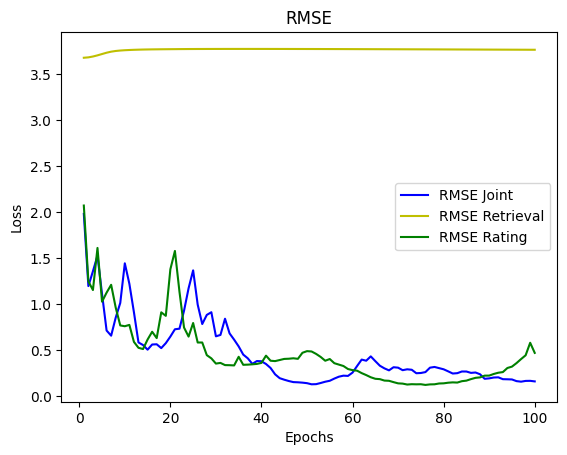

In [135]:
RMSE_joint = history_joint_model.history['root_mean_squared_error']
RMSE_retrieval = history_retrieval_model.history['root_mean_squared_error']
RMSE_rating = history_rating_model.history['root_mean_squared_error']

draw_plot('RMSE', RMSE_joint,RMSE_retrieval,RMSE_rating)

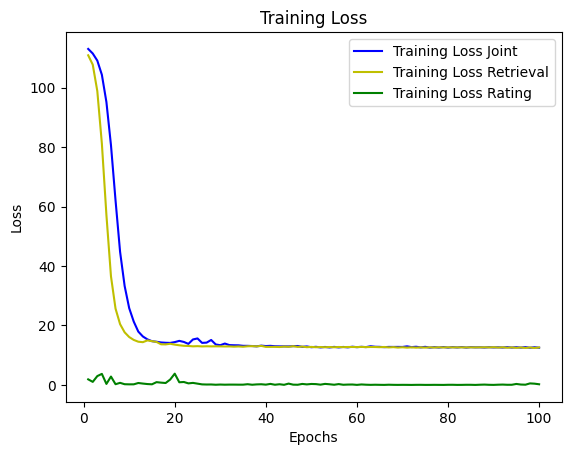

In [136]:
total_loss_values_joint = history_joint_model.history['total_loss']
total_loss_values_retrieval = history_retrieval_model.history['total_loss']
total_loss_values_rating = history_rating_model.history['total_loss']

draw_plot('Training Loss', total_loss_values_joint,total_loss_values_retrieval,total_loss_values_rating)

## Making predictions

In [137]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(["3avc3TUJioP8XGD0bLK9xtV7uIG3"]),
      "book_isbn": np.array(["09781880685358"])
  })
print("Predicted rating:")
print(predicted_rating)

Predicted rating:
tf.Tensor([[4.0069346]], shape=(1, 1), dtype=float32)


In [138]:
user_id = ["3avc3TUJioP8XGD0bLK9xtV7uIG3"]
isbn_list = set(books_df["isbn"])
for isbn in isbn_list:
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
      "user_id": np.array(user_id),
      "book_isbn": np.array([isbn])
    })
    print(predicted_rating)

tf.Tensor([[4.0069346]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2235281]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.8947926]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.9637394]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1897407]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.2410717]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.37718]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.41995]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.2288046]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.6532817]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.9423974]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.1799664]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4210796]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.754629]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5772004]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3793874]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.514282]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4130683]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.702653]], shape=(1, 

tf.Tensor([[5.9740944]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.483801]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.885508]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9565337]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.6008015]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.55873]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.7461324]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.4424143]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.323036]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.7183514]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4683414]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.709744]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.724716]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.2303042]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.5219584]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.382767]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.281202]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.059575]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.413484]], shape=(1, 1), 

tf.Tensor([[1.9107766]], shape=(1, 1), dtype=float32)
tf.Tensor([[6.197654]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.6108086]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3548036]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.2082925]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4653506]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.259366]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.123153]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.222628]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4500017]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1374843]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.418985]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6661994]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.811224]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.041642]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.111573]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.914483]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3394637]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.4620724]], shape=(1, 1)

tf.Tensor([[4.426463]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.399629]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.9307566]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.2346296]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.0868173]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.4747496]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.3799486]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.6666822]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4968867]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.410354]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.00765]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.020681]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.413659]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.0922318]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.9276035]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.373969]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.382326]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.432601]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.325861]], shape=(1, 1), 

tf.Tensor([[4.7155814]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.466877]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.4553742]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.6805186]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.629012]], shape=(1, 1), dtype=float32)
tf.Tensor([[3.5154943]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.17877]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.709362]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.9335136]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.351826]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.563416]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.450037]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.395616]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.2503133]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.8890224]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.448112]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.2858524]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.6105356]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.3813572]], shape=(1, 1),

### Save the model 

In [139]:
model.retrieval_task = tfrs.tasks.Retrieval()  # Removes the metrics.
model.compile()
model.save("final_model")

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


In [140]:
# load model
model = tf.keras.models.load_model("final_model")

In [141]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("final_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)

### Tf Lite

In [142]:
interpreter = tf.lite.Interpreter(model_path="final_model.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_book_isbn:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Input name: serving_default_user_id:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall:0
Output shape: []
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall:2
Output shape: [1 1]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall:1
Output shape: []
Output data type: <class 'numpy.float32'>



In [143]:
# Prepare the input data
input_data_isbn = np.array([b'09780143036357'], dtype=np.bytes_)
input_data_user_id = np.array(['3avc3TUJioP8XGD0bLK9xtV7uIG3'], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data_isbn)
interpreter.set_tensor(input_details[1]['index'], input_data_user_id)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_probabilities = interpreter.get_tensor(output_details[1]['index'])
output_data_score = interpreter.get_tensor(output_details[2]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
probabilities = output_data_probabilities.squeeze()
#score = output_data_score.squeeze()

# Print the results
#print("Prediction:", prediction)
print("Probability:", probabilities)
#print("Score:", score)

Probability: 3.5562315


### Tensorflow recommenders 

#### Brute Force

In [144]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=20)
# recommends books out of the entire books dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((books.batch(100), books.batch(100).map(model.book_model)))
)

# Get recommendations.
_, isbns = index(np.array(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"]))
print(f"Recommendations for user: {isbns[0, :10]}")

Recommendations for user: [b'09781857024074' b'09780375701801' b'09780465014903' b'09780520239326'
 b'09780140286014' b'09780618257768' b'09780590428880' b'09780321209184'
 b'09780393703351' b'09780226204055']


#### Save the brute force model

In [145]:
index.save("final_model")

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


In [146]:
# test loading 
loaded = tf.saved_model.load("final_model")

# Pass a user id in, get top predicted movie titles back.
scores, isbns = loaded(["Pgzb07La4DUNOhYPzYXHA7CdfNi1"])

print(f"Recommendations: {isbns[0][:5]}")

Recommendations: [b'09781857024074' b'09780375701801' b'09780465014903' b'09780520239326'
 b'09780140286014']


#### TFLite for the model 

In [147]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("final_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)

#### Tf lite testing 

In [148]:
interpreter = tf.lite.Interpreter(model_path="final_model.tflite")
interpreter.allocate_tensors()

#Get input details
input_details = interpreter.get_input_details()
for input_tensor in input_details:
    print("Input name:", input_tensor["name"])
    print("Input shape:", input_tensor["shape"])
    print("Input data type:", input_tensor["dtype"])
    print()
#Get output details
output_details = interpreter.get_output_details()
for output_tensor in output_details:
    print("Output name:", output_tensor["name"])
    print("Output shape:", output_tensor["shape"])
    print("Output data type:", output_tensor["dtype"])
    print()

Input name: serving_default_input_1:0
Input shape: [1]
Input data type: <class 'numpy.bytes_'>

Output name: StatefulPartitionedCall_1:0
Output shape: [ 1 20]
Output data type: <class 'numpy.float32'>

Output name: StatefulPartitionedCall_1:1
Output shape: [ 1 20]
Output data type: <class 'numpy.bytes_'>



In [149]:
# Prepare the input data
input_data = np.array(["zwVJUfdC0oa9hWWp9uK0hRTM71j1"], dtype=np.bytes_)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()

# Retrieve the output results
output_details = interpreter.get_output_details()

output_data_prediction = interpreter.get_tensor(output_details[0]['index'])
output_data_classes = interpreter.get_tensor(output_details[1]['index'])

# Process the output
#prediction = output_data_prediction.squeeze()
classes = output_data_classes.squeeze().astype(str)

# Print the results
#print("Prediction:", prediction)
print("Classes:", classes)

Classes: ['09780851621814' '09780253203182' '09780738539560' '09780446617451'
 '09780826323576' '09780340766163' '09781580175203' '09780226142814'
 '09780552773089' '09780609804247' '09780471738848' '09780471678786'
 '09780143104902' '09780753459645' '09780486422459' '09780596006624'
 '09781582406121' '09780495097990' '09780822001836' '09780375507908']


In [151]:
import firebase_admin
from firebase_admin import ml
from firebase_admin import credentials

firebase_admin.initialize_app(
  credentials.Certificate('firebase-key'),
  name="app101",
  options={
      'storageBucket': 'storage-url',
  })


In [152]:
#Upload model

In [153]:
source = ml.TFLiteGCSModelSource.from_tflite_model_file('final_model.tflite')
tflite_format = ml.TFLiteFormat(model_source=source)
model = ml.Model(display_name="final_model", model_format=tflite_format)
new_model = ml.create_model(model)
ml.publish_model(new_model.model_id)
print(new_model.model_id)

21878292


In [154]:
#Update model

In [155]:
model = ml.get_model(new_model.model_id)
source = ml.TFLiteGCSModelSource.from_tflite_model_file('final_model.tflite')
model.mode_format = ml.TFLiteFormat(model_source=source)
model.display_name = "final_model"
updated_model = ml.update_model(model)
ml.publish_model(updated_model.model_id)